In [1]:
########## Import required libraries ###########
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import v2
!pip install torchsummary

In [3]:
############## Get data loaded with required transformation ##################

# Train data transformations
train_transforms = v2.Compose([
    # Randomly apply CenterCrop(22) with a 10% probability
    # Purpose: Introduce variability during training by randomly cropping images.
    v2.RandomApply([v2.CenterCrop(22), ], p=0.1),


    # Randomly rotate the image by an angle between -15 and +15 degrees
    # fill = 0 to fill with black pixels as background
    # Purpose: Augment the training data by introducing random rotations.
    v2.RandomRotation((-10., 10.), fill=0),


    # Resize the image to 28x28 pixels (works through interpolation)
    # Purpose: Standardize the image size for model input.(To maintain the consistent size of the images, resize should be done after all cropping/rotation which have the possibility of altering the image size)
    v2.Resize((28, 28)),

    # Convert the image to a PyTorch tensor
    # Purpose: Prepare the image data for neural network input.
    # transforms.ToTensor(),  # this works in PytorchV1
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),

    # Normalize the pixel values using mean 0.1307 and standard deviation 0.3081
    # Purpose: Normalize pixel values to improve model convergence and performance.
    v2.Normalize(mean=[0.1307], std = [0.3081])
])


# Test data transformations
test_transforms = v2.Compose([
    # Convert the image to a PyTorch tensor
    # Purpose: Prepare the image data for neural network input.
    # transforms.ToTensor(),  # this works in PytorchV1
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),

    # Normalize the pixel values using mean 0.1307 and standard deviation 0.3081
    # Purpose: Normalize pixel values to improve model convergence and performance.
    v2.Normalize(mean=[0.1307], std = [0.3081])
])



#### Get training and test data along with transformations
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)  # download and load the "training" data of MNIST and apply train_transform
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)   # download and load the "test" data of MNIST and apply test_transform


# Set seed for reproducible results
torch.manual_seed(12)


# Define the batch size for data loading
batch_size = 256

# Create a dictionary of keyword arguments (kwargs) for DataLoader
kwargs = {
    'batch_size': batch_size,   # Set the batch size for each batch of data
    'shuffle': True,            # ensures that the model encounters a diverse mix of data during training, leading to better learning and generalization (during testing, the order of data doesn’t impact the model’s predictions)
    'num_workers': 2,           # Number of worker threads for data loading ( each worker will deal with batchsize/num_workers set of data under a batch) # parallel processing-> reduces overall time
    'pin_memory': True          # Enable pinning memory for faster GPU transfer
}

# Create DataLoader instances for test and train data
# Note: test_data should be loaded for test_loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)   # load test data
train_loader = torch.utils.data.DataLoader(train_data, **kwargs) # load train data


In [6]:
#Define the model
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        )  # n_in = 28, n_out = 26, r_in = 1, r_out = 3, j_in = 1, s=1, j_out = 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # n_in = 26, n_out = 24, r_in = 3, r_out = 5, j_in = 1, s=1, j_out = 1



        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # n_in = 24, n_out = 24, r_in = 5, r_out = 5, j_in = 1, s=1, j_out = 1
        self.pool1 = nn.MaxPool2d(2, 2) # n_in = 24, n_out = 12, r_in = 5, r_out = 6, j_in = 1, s=2, j_out = 2


        
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20,momentum=0.2),
            nn.Dropout(dropout_value)
        ) # n_in = 12, n_out = 10, r_in = 6, r_out = 10, j_in = 2, s=1, j_out = 2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32,momentum=0.2),
            nn.Dropout(dropout_value)
        ) # n_in = 10, n_out = 10, r_in = 10, r_out = 14, j_in = 2, s=1, j_out = 2


        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )  # n_in = 10, n_out = 10, r_in = 14, r_out = 14, j_in = 2, s=1, j_out = 2
        self.pool2 = nn.MaxPool2d(2, 2) # n_in = 10, n_out = 5, r_in = 14, r_out = 16, j_in = 2, s=2, j_out = 4



        # CONVOLUTION BLOCK 3 
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16,momentum=0.2),
            nn.Dropout(dropout_value)
        ) # n_in = 5, n_out = 5, r_in = 16, r_out = 24, j_in = 4, s=1, j_out = 4

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32,momentum=0.2),
            nn.Dropout(dropout_value)
        ) # n_in = 5, n_out = 5, r_in = 24, r_out = 32, j_in = 4, s=1, j_out = 4
        
        

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # GAP reduces spatial dimensions to 1x1

        # define fully connected layer
        self.fc = nn.Linear(32, 10)



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.global_avg_pool(x)     # Apply GAP
        x = x.view(x.size(0),-1)        # Flatten for fully connected layer
        x = self.fc(x)                  # Get the output from the fully connected layer
        return F.log_softmax(x,dim=1)   # Apply log_softmax activation function for the output layer.


In [7]:
# Get model summary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           2,592
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             288
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           2,160
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
          Dropout-14           [-1, 20,

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [9]:


from tqdm import tqdm  # Import tqdm for progress bars

def GetCorrectPredCount(pPrediction, pLabels):
    # This function computes the number of correct predictions by comparing
    # the predicted labels (with the highest probability) against the true labels.
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    # Initialize lists to store training losses and accuracies if not already present
    global train_losses
    global train_acc

    model.train()  # Set the model to training mode
    pbar = tqdm(train_loader)  # Wrap the data loader with tqdm for a progress bar

    train_loss = 0  # Initialize total training loss
    correct = 0  # Initialize total number of correct predictions
    processed = 0  # Initialize total number of processed samples

    for batch_idx, (data, target) in enumerate(pbar):
        # Move the batch data and labels to the specified device (GPU)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Clear the gradients of all optimized variables

        # Forward pass: compute predicted outputs by passing inputs to the model
        pred = model(data)

        # Compute loss: calculate the batch loss by comparing predicted and true labels
        loss = criterion(pred, target)
        train_loss += loss.item()  # Aggregate the loss

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        optimizer.step()  # Perform a single optimization step (parameter update)

        correct += GetCorrectPredCount(pred, target)  # Update total correct predictions for the batch
        processed += len(data)  # Update total processed samples of batch

        # Update progress bar description with current loss and accuracy
        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    # Calculate and store the average accuracy and loss for this training epoch of training data
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader, criterion):
    # Initialize lists to store test losses and accuracies if not already present
    global test_acc
    global test_losses

    model.eval()  # Set the model to evaluation mode
    test_loss = 0  # Initialize total test loss
    correct = 0  # Initialize total number of correct predictions

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (data, target) in enumerate(test_loader):
            # Move the batch data and labels to the specified device (GPU)
            data, target = data.to(device), target.to(device)

            output = model(data)  # Compute output by passing inputs to the model
            test_loss += criterion(output, target).item()  # Sum up batch loss

            correct += GetCorrectPredCount(output, target)  # Update total correct predictions for each batch in test data

    # Calculate and store the average loss and accuracy for this test run
    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    # Print test results
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


In [10]:

# Initialize the model and move it to the device ( GPU )
model = Net().to(device)

# Set up the optimizer with stochastic gradient descent with learning rate and momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)

# Configure a learning rate scheduler that decays the learning rate by a factor of 0.1 every 15 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9, verbose=True)

# Define the loss function as negative log likelihood loss.
criterion = F.nll_loss  # nn.CrossEntropyLoss(reduction='sum')

# Set the number of epochs for training
num_epochs = 20

# Loop over the dataset multiple times, once for each epoch
for epoch in range(1, num_epochs):
  # Print the current epoch number
  print(f'Epoch {epoch}')

  # Call the train function, passing in the model, device, data loader, optimizer, and loss function
  train(model, device, train_loader, optimizer, criterion)

  # After training, evaluate the model on test_loader
  test(model, device, test_loader, criterion)

  # Update the learning rate based on the scheduler
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.1240 Batch_id=234 Accuracy=79.50: 100%|██████████| 235/235 [00:14<00:00, 16.39it/s]


Test set: Average loss: 0.0004, Accuracy: 9708/10000 (97.1%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0918 Batch_id=234 Accuracy=96.69: 100%|██████████| 235/235 [00:14<00:00, 16.12it/s]


Test set: Average loss: 0.0002, Accuracy: 9807/10000 (98.1%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0736 Batch_id=234 Accuracy=97.53: 100%|██████████| 235/235 [00:14<00:00, 16.31it/s]


Test set: Average loss: 0.0002, Accuracy: 9867/10000 (98.7%)

Adjusting learning rate of group 0 to 9.0000e-03.
Epoch 4


Train: Loss=0.0509 Batch_id=234 Accuracy=97.99: 100%|██████████| 235/235 [00:14<00:00, 16.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9887/10000 (98.9%)

Adjusting learning rate of group 0 to 9.0000e-03.
Epoch 5


Train: Loss=0.0297 Batch_id=234 Accuracy=98.22: 100%|██████████| 235/235 [00:14<00:00, 16.31it/s]


Test set: Average loss: 0.0001, Accuracy: 9911/10000 (99.1%)

Adjusting learning rate of group 0 to 9.0000e-03.
Epoch 6


Train: Loss=0.0109 Batch_id=234 Accuracy=98.26: 100%|██████████| 235/235 [00:14<00:00, 16.23it/s]


Test set: Average loss: 0.0001, Accuracy: 9912/10000 (99.1%)

Adjusting learning rate of group 0 to 8.1000e-03.
Epoch 7


Train: Loss=0.0180 Batch_id=234 Accuracy=98.55: 100%|██████████| 235/235 [00:14<00:00, 16.45it/s]


Test set: Average loss: 0.0001, Accuracy: 9909/10000 (99.1%)

Adjusting learning rate of group 0 to 8.1000e-03.
Epoch 8


Train: Loss=0.1502 Batch_id=234 Accuracy=98.58: 100%|██████████| 235/235 [00:14<00:00, 16.06it/s]


Test set: Average loss: 0.0001, Accuracy: 9927/10000 (99.3%)

Adjusting learning rate of group 0 to 8.1000e-03.
Epoch 9


Train: Loss=0.0203 Batch_id=234 Accuracy=98.59: 100%|██████████| 235/235 [00:14<00:00, 16.67it/s]


Test set: Average loss: 0.0001, Accuracy: 9923/10000 (99.2%)

Adjusting learning rate of group 0 to 7.2900e-03.
Epoch 10


Train: Loss=0.0378 Batch_id=234 Accuracy=98.68: 100%|██████████| 235/235 [00:14<00:00, 15.90it/s]


Test set: Average loss: 0.0001, Accuracy: 9926/10000 (99.3%)

Adjusting learning rate of group 0 to 7.2900e-03.
Epoch 11


Train: Loss=0.0437 Batch_id=234 Accuracy=98.73: 100%|██████████| 235/235 [00:14<00:00, 16.57it/s]


Test set: Average loss: 0.0001, Accuracy: 9927/10000 (99.3%)

Adjusting learning rate of group 0 to 7.2900e-03.
Epoch 12


Train: Loss=0.0371 Batch_id=234 Accuracy=98.80: 100%|██████████| 235/235 [00:14<00:00, 16.18it/s]


Test set: Average loss: 0.0001, Accuracy: 9941/10000 (99.4%)

Adjusting learning rate of group 0 to 6.5610e-03.
Epoch 13


Train: Loss=0.0073 Batch_id=234 Accuracy=98.81: 100%|██████████| 235/235 [00:14<00:00, 16.62it/s]


Test set: Average loss: 0.0001, Accuracy: 9939/10000 (99.4%)

Adjusting learning rate of group 0 to 6.5610e-03.
Epoch 14


Train: Loss=0.0188 Batch_id=234 Accuracy=98.89: 100%|██████████| 235/235 [00:14<00:00, 15.96it/s]


Test set: Average loss: 0.0001, Accuracy: 9933/10000 (99.3%)

Adjusting learning rate of group 0 to 6.5610e-03.
Epoch 15


Train: Loss=0.0245 Batch_id=234 Accuracy=98.84: 100%|██████████| 235/235 [00:14<00:00, 16.49it/s]


Test set: Average loss: 0.0001, Accuracy: 9935/10000 (99.3%)

Adjusting learning rate of group 0 to 5.9049e-03.
Epoch 16


Train: Loss=0.0103 Batch_id=234 Accuracy=98.93: 100%|██████████| 235/235 [00:14<00:00, 16.11it/s]


Test set: Average loss: 0.0001, Accuracy: 9937/10000 (99.4%)

Adjusting learning rate of group 0 to 5.9049e-03.
Epoch 17


Train: Loss=0.0157 Batch_id=234 Accuracy=98.96: 100%|██████████| 235/235 [00:14<00:00, 16.35it/s]


Test set: Average loss: 0.0001, Accuracy: 9945/10000 (99.5%)

Adjusting learning rate of group 0 to 5.9049e-03.
Epoch 18


Train: Loss=0.0056 Batch_id=234 Accuracy=99.00: 100%|██████████| 235/235 [00:14<00:00, 16.23it/s]


Test set: Average loss: 0.0001, Accuracy: 9942/10000 (99.4%)

Adjusting learning rate of group 0 to 5.3144e-03.
Epoch 19


Train: Loss=0.0189 Batch_id=234 Accuracy=99.04: 100%|██████████| 235/235 [00:14<00:00, 16.34it/s]


Test set: Average loss: 0.0001, Accuracy: 9947/10000 (99.5%)

Adjusting learning rate of group 0 to 5.3144e-03.


Text(0.5, 1.0, 'Test Accuracy')

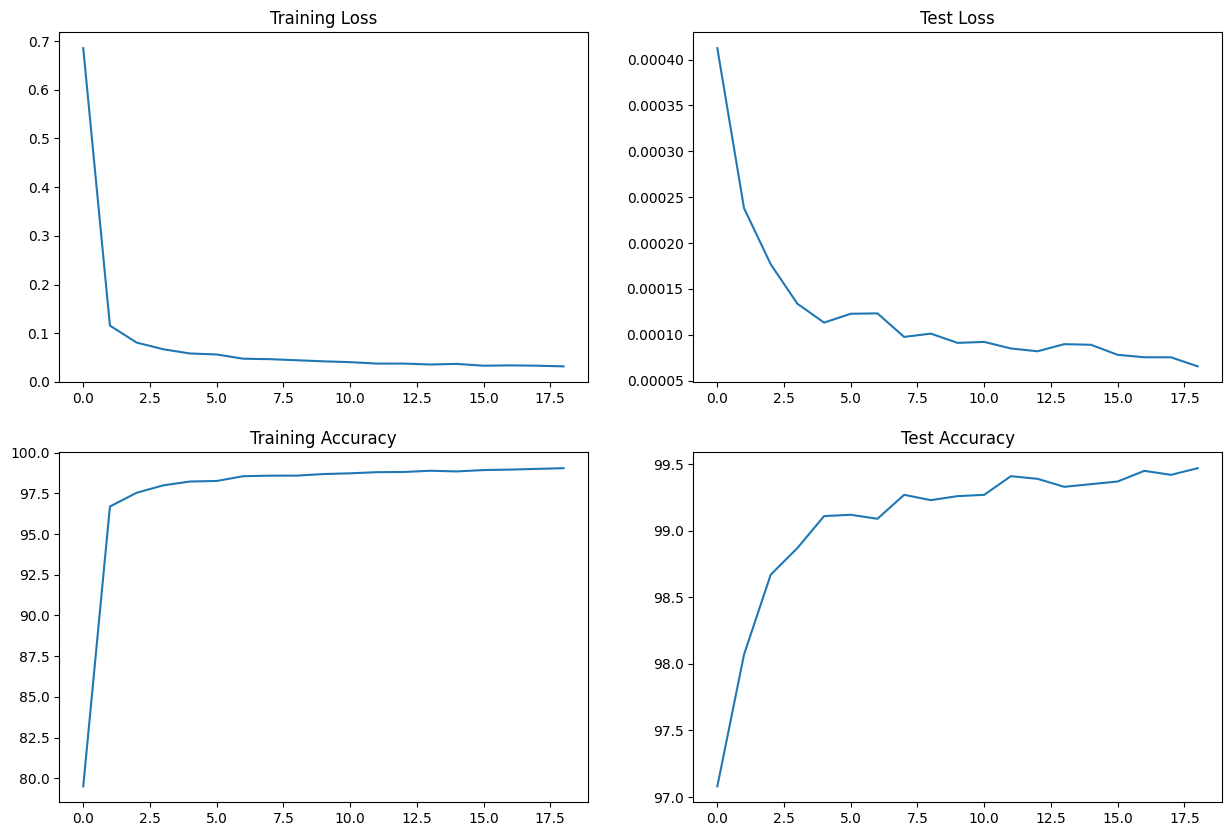

In [11]:
### Plots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")